In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

X = np.load('/content/drive/MyDrive/Deep2025/X_voxel_full.npy')
y = np.load('/content/drive/MyDrive/Deep2025/y_voxel_full.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("📦 X shape:", X.shape)
print("🏷️ y shape:", y.shape)

✅ دیتا لود شد!
📦 X shape: (3991, 32, 32, 32, 1)
🏷️ y shape: (3991,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:

# --- Augmentation functions ---
def rotate_voxel(voxel, axis):
    if axis == 'x':
        return np.rot90(voxel, k=1, axes=(1, 2))
    elif axis == 'y':
        return np.rot90(voxel, k=1, axes=(0, 2))
    elif axis == 'z':
        return np.rot90(voxel, k=1, axes=(0, 1))

def flip_voxel(voxel, axis):
    return np.flip(voxel, axis=axis)

def add_noise(voxel, noise_level=0.05):
    noise = np.random.normal(0, noise_level, voxel.shape)
    return np.clip(voxel + noise, 0.0, 1.0)

# --- Compose augmentation ---
def augment_voxel(voxel):
    # Remove channel dimension temporarily
    voxel = voxel[..., 0]

    # Random rotation
    for axis in ['x', 'y', 'z']:
        if np.random.rand() < 0.5:
            voxel = rotate_voxel(voxel, axis)

    # Random flip
    for axis in [0, 1, 2]:
        if np.random.rand() < 0.5:
            voxel = flip_voxel(voxel, axis)

    # Random noise
    if np.random.rand() < 0.5:
        voxel = add_noise(voxel)

    # Add channel back
    return voxel[..., np.newaxis]

In [ ]:
# Augment all training samples
X_train_aug = np.array([augment_voxel(voxel) for voxel in X_train])
print("✅ X_train_aug ", X_train_aug.shape)

✅ X_train_aug آماده شد: (3192, 32, 32, 32, 1)


In [ ]:
X_train_combined = np.concatenate([X_train, X_train_aug], axis=0)
y_train_combined = np.concatenate([y_train, y_train], axis=0)

In [ ]:
num_classes = len(np.unique(y))
print(num_classes)

10


In [ ]:
print("Number of classes:", num_classes)
print("Unique y values in training:", np.unique(y_train_combined))

Number of classes: 10
Unique y values in training: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

model = Sequential([
    Conv3D(32, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=2),
    Dropout(0.5),

    Conv3D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=2),
    Dropout(0.3),

    Conv3D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=2),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_combined, y_train_combined,
    epochs=40,
    validation_data=(X_val, y_val),
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/40
798/798 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3079 - loss: 3.9804 - val_accuracy: 0.6195 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 2/40
798/798 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4368 - loss: 1.5358 - val_accuracy: 0.7034 - val_loss: 0.8372 - learning_rate: 0.0010
Epoch 3/40
798/798 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4698 - loss: 1.4117 - val_accuracy: 0.7484 - val_loss: 0.7804 - learning_rate: 0.0010
Epoch 4/40
798/798 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4969 - loss: 1.3638 - val_accuracy: 0.6608 - val_loss: 0.8660 - learning_rate: 0.0010
Epoch 5/40
798/798 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5299 - loss: 1.2586 - val_accuracy: 0.8098 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 6/40
798/798 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5222 - loss: 1.2323 - val_accuracy: 0.8048 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 7/40
798/798 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5437 - loss: 1.2007 -

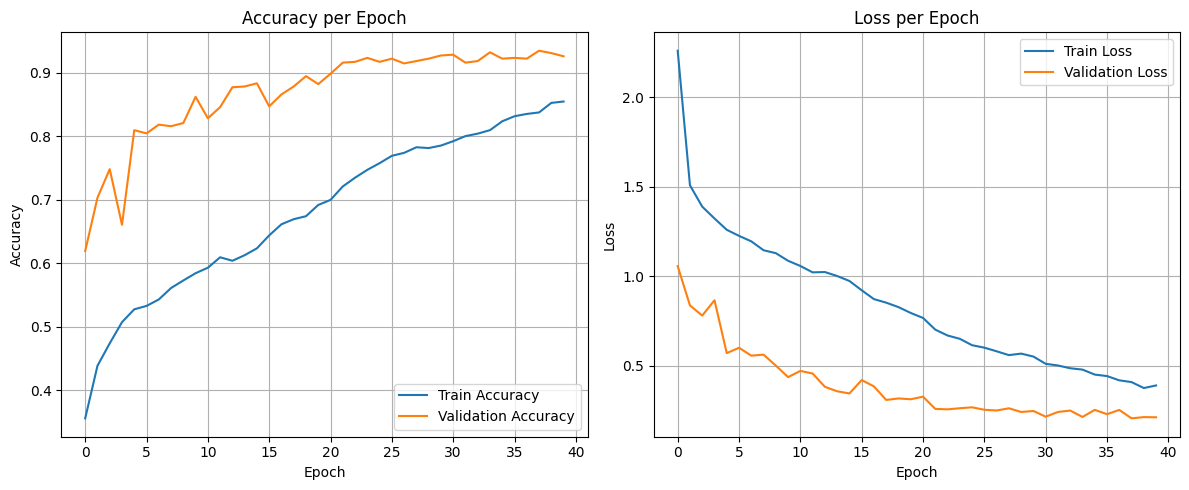

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


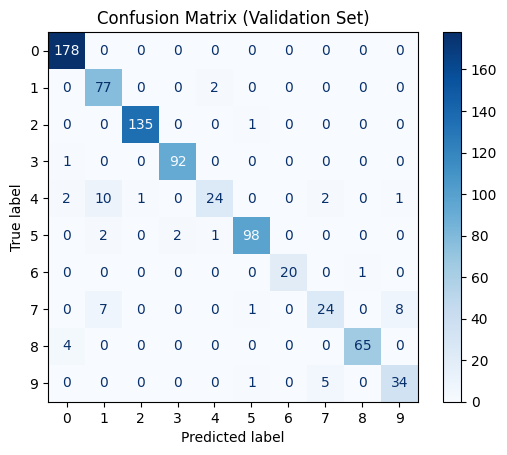

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_val).argmax(axis=1)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [ ]:
model.save("voxelnet_model.h5")
model.save("voxelnet_model.keras")  #  "voxelnet_model.keras"